## Part 1 of the LIFE SCIENCE DATA SCIENTIST RECRUITMENT TASK

Author: Liubov Shilova

Date: 16.01.2023

The current notebook presents code used for training and testing an shallow-learning model for predicting patients with asthma.

In [37]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import GroupShuffleSplit 
from sklearn.metrics import accuracy_score, auc, f1_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve


from sklearn.model_selection import StratifiedKFold

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

%matplotlib inline

## General overview of the dataset

- The dataset has no missing values.
- 9 features, 2 categorical target variable (Asthma, AsthmaAttack).
- Categorical features: Gender, Smoke. 2 classes in both, balanced, can be decoded with one-hot-encoding or ordinal encoding. Patient_ID should not affect the target variable and is thus ignored.
- Numerical features: Age, Height_Cm, Day_ID, AsthmaAttack, PEF, FEV1, FVC.
- The dataset is disbalanced, more than 70% of patients have asthma.

In [5]:
def value_of_metrics(y_true, y_pred):
    """
    Print all metrics for results of classification model,
    Plot the ROC.
    """
    print('Accuracy: ', accuracy_score(y_true, y_pred))
    print('Recall: ', recall_score(y_true, y_pred))
    print('Precision: ', precision_score(y_true, y_pred))  
    print('F1: ', f1_score(y_true, y_pred))
    print('Roc_AUC: ', roc_auc_score(y_true, y_pred))
    print('Confusion Matrix: ')
    print(pd.DataFrame(confusion_matrix(y_true, y_pred)))
    
    fpr, tpr, threshold = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [39]:
# Load data
df = pd.read_csv("lsds_recruiting_task_inputdata.csv")
df.head()

,Patient_ID,Gender,Age,Smoke,Height_Cm,Asthma,Day_ID,AsthmaAttack,PEF,FEV1,FVC
0,ROA376C0191000,Male,82,Yes,175,Yes,1,0,438.011,2.709,3.764
1,ROA376C0191000,Male,82,Yes,175,Yes,2,0,397.175,2.909,3.514
2,ROA376C0191000,Male,82,Yes,175,Yes,3,0,432.151,2.690,3.593
3,ROA376C0191000,Male,82,Yes,175,Yes,4,0,416.926,2.828,3.486
4,ROA376C0191000,Male,82,Yes,175,Yes,5,0,424.322,2.955,3.524


In [40]:
# Separate data for Task 1
df1 = df[['Patient_ID', 'Gender', 'Age', 'Smoke', 'Height_Cm', 'Asthma', 'PEF', 'FEV1', 'FVC']].copy()

In [41]:
df1.describe(include = 'all')

,Patient_ID,Gender,Age,Smoke,Height_Cm,Asthma,PEF,FEV1,FVC
count,59136,59136,59136.000000,59136,59136.000000,59136,59136.000000,59136.000000,59136.000000
unique,264,2,NaN,2,NaN,2,NaN,NaN,NaN
top,ROA376C0191005,Male,NaN,Yes,NaN,Yes,NaN,NaN,NaN
freq,224,30912,NaN,33600,NaN,41664,NaN,NaN,NaN
mean,NaN,NaN,48.291667,NaN,170.984848,NaN,492.066005,3.164645,4.021530
std,NaN,NaN,20.568108,NaN,9.160669,NaN,57.310658,0.742668,0.867348
min,NaN,NaN,15.000000,NaN,152.000000,NaN,170.720000,0.858000,0.875000
25%,NaN,NaN,29.750000,NaN,163.000000,NaN,452.247750,2.652000,3.405000
50%,NaN,NaN,47.500000,NaN,172.000000,NaN,490.895000,3.123000,3.873000
75%,NaN,NaN,66.000000,NaN,178.250000,NaN,532.551250,3.720000,4.799000


<AxesSubplot:ylabel='Asthma'>

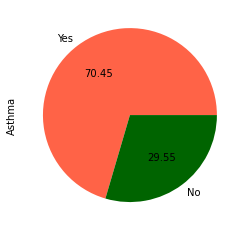

In [42]:
# Check for disbalance
df1.Asthma.value_counts().plot.pie(autopct = '%.2f', colors = ['tomato', 'darkgreen'] )

## Preprocessing

In [43]:
# Encode categorical features
asthma_smoke_mapping = {'No':0,'Yes':1}
gender_mapping = {'Male':0, 'Female':1 }

df1['Asthma'] = df1['Asthma'].map(asthma_smoke_mapping)
df1['Smoke'] = df1['Smoke'].map(asthma_smoke_mapping)
df1['Gender'] = df1['Gender'].map(gender_mapping)

In [44]:
# Add a feature of FEV1/FVC ratio
df1['FEV1_FVC_ratio'] = df1['FEV1'] / df1['FVC']

# Reorder columns
df1 = df1[['Patient_ID', 'Age', 'Height_Cm', 'PEF', 'FEV1', 'FVC', 'FEV1_FVC_ratio', 'Gender', 'Smoke', 'Asthma']]

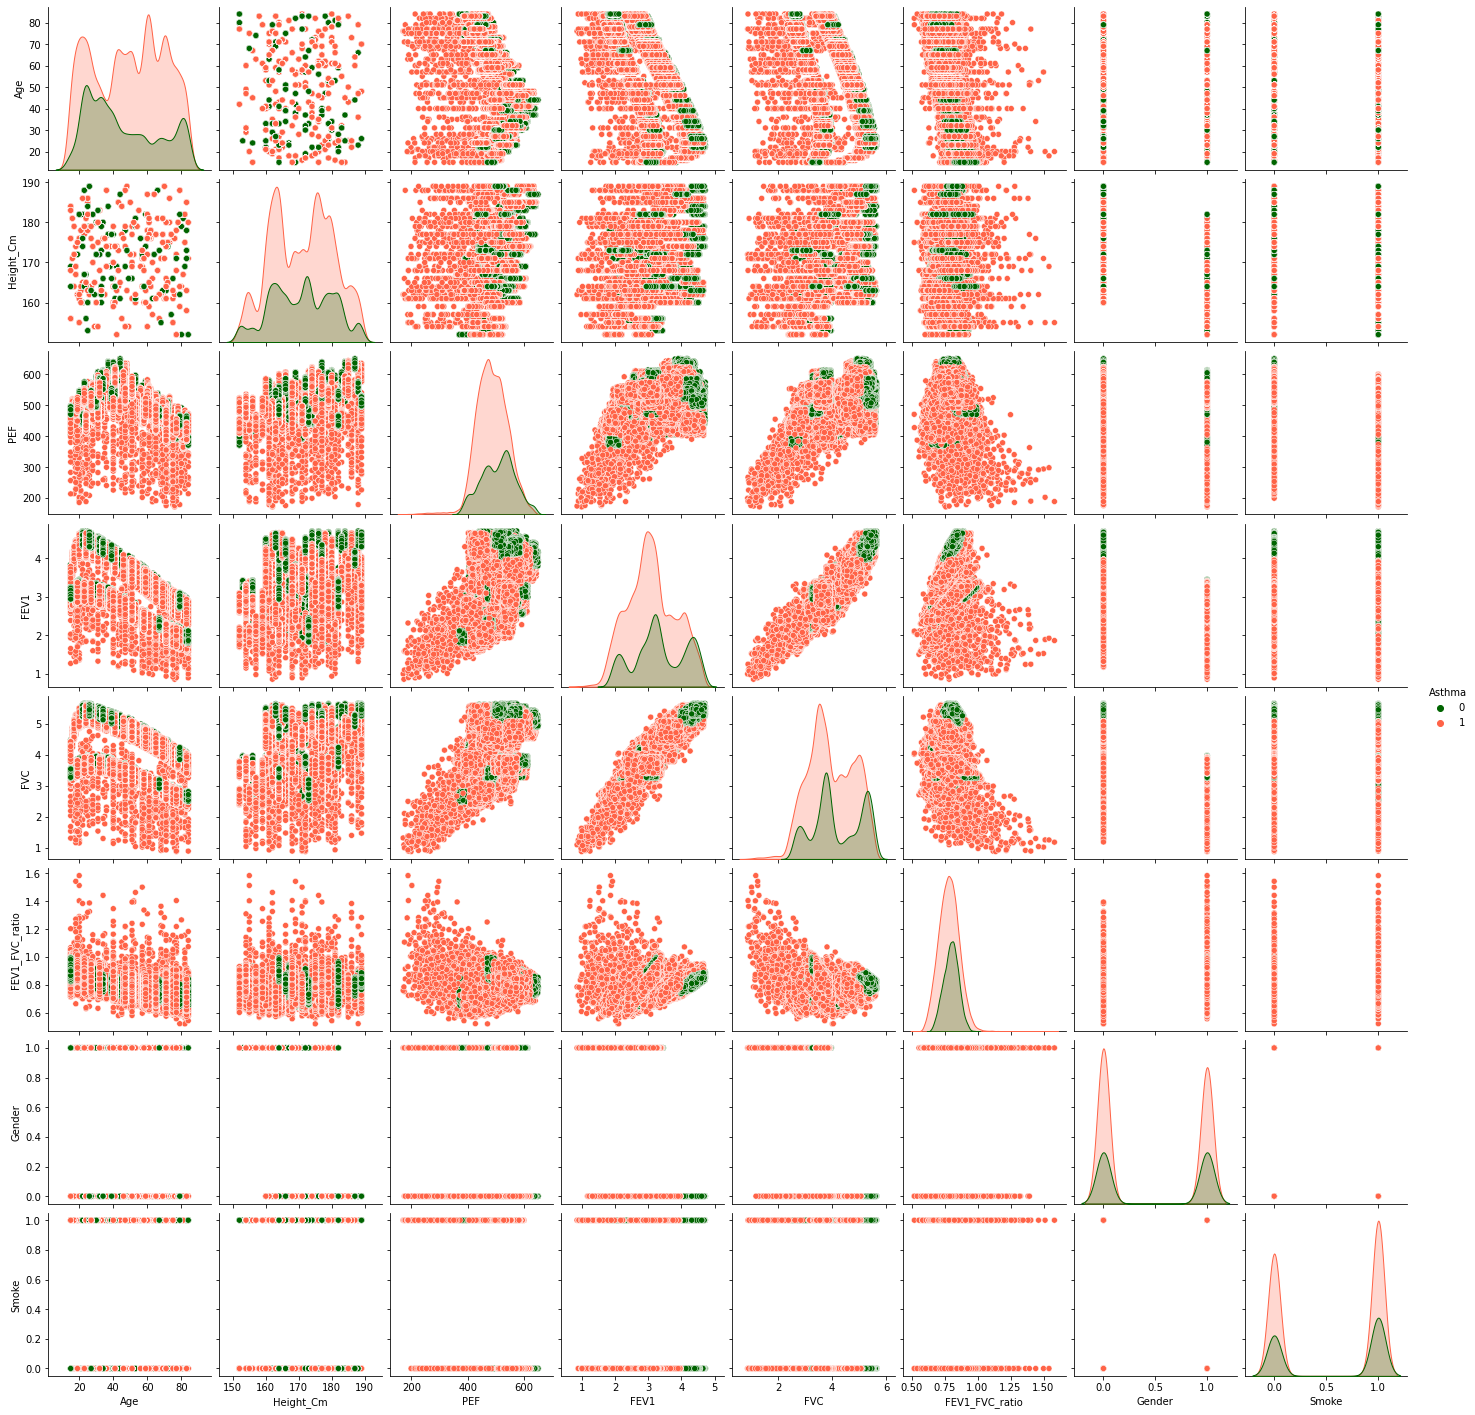

In [14]:
sns.pairplot(df1, hue = 'Asthma', palette = {0:'darkgreen', 1:'tomato'})

In [45]:
#splitting the patients into a train (80%) and a test (20%) dataset.
splitter = GroupShuffleSplit(test_size = 0.2, n_splits = 1, random_state = 7)
split = splitter.split(df1, groups = df1['Patient_ID'])
train_inds, test_inds = next(split)

train = df1.iloc[train_inds].reset_index(drop = True)
test = df1.iloc[test_inds].reset_index(drop = True)

In [46]:
#MinMaxScaling of numerical features
train_num_features = train.select_dtypes(['float64', 'int64'])
test_num_features = test.select_dtypes(['float64', 'int64'])                                        
                                   
scaler = preprocessing.MinMaxScaler()

scaler.fit(train_num_features)

train_standard = pd.DataFrame(scaler.transform(train_num_features), columns = train_num_features.columns)
test_standard = pd.DataFrame(scaler.transform(test_num_features), columns = test_num_features.columns)

In [47]:
# Separate features and target variable
X_train = train_standard.drop(['Asthma'], axis = 1).copy()
y_train = train_standard['Asthma'].copy()
X_test = test_standard.drop(['Asthma'], axis = 1).copy()
y_test = test_standard['Asthma'].copy()

## Training and testing models

In [48]:
############DEFINE MODELS##########################################

model_parameters = {
    
     'XGBoost': {
         'model':XGBClassifier(),
         'params': {'gamma': [0.25], 
                    'learning_rate': [0.1], 
                    'max_depth': [3], 
                    'n_estimators': [45], 
                    'reg_lambda': [0], 
                    'scale_pos_weight': [1],         
         }
     },
     'SVM': {
         'model': svm.SVC(gamma = 'auto', class_weight = 'balanced'),
         'params' : {
             'C': [10, 11, 12],
             'kernel': ['rbf','linear','poly']
         }  
     },
    'Random_Forest': {
        'model': BalancedRandomForestClassifier(),
        'params' : {
            'n_estimators': [40, 43, 45, 47, 50],
            'criterion':['gini', 'entropy'],
            'max_depth':[5, 6, 7, 8],
            'max_features':['sqrt', 'log2'],
        }
     },
     'KNN': {
         'model': KNeighborsClassifier(),
         'params' : {
             'n_neighbors':[6, 7, 8]
         }    
    },
     'Logistic_Regression' : {
         'model': LogisticRegression(),
         'params': { 
             'penalty':['l1', 'l2'], 
             'C':[9, 10, 11], 
             'solver':['saga', 'liblinear']
         }
     }
}


############CV ON MODELS##########################################

#Train and find the best hyperparameters with cross-validation
best_results = []

for model_name, parameters in model_parameters.items():
    
    print(f"Training {model_name} model.")
    
    cv = StratifiedKFold(n_splits = 4,shuffle = False)
    
    grid =  GridSearchCV(estimator = parameters['model'], 
                         param_grid = parameters['params'],
                         scoring = 'roc_auc',
                         cv = cv, n_jobs = 8, 
                         return_train_score = False)
    
    grid.fit(X_train, y_train)
    
    best_results.append({
        'model': model_name,
        'best_score': grid.best_score_,
        'best_params': grid.best_params_
    })
    
cv_results = pd.DataFrame(best_results, columns = ['model','best_score','best_params'])
cv_results

Training XGBoost model.
Training SVM model.
Training Random_Forest model.
Training KNN model.
Training Logistic_Regression model.


,model,best_score,best_params
0,XGBoost,0.651486,"{'gamma': 0.25, 'learning_rate': 0.1, 'max_dep..."
1,SVM,0.872740,"{'C': 11, 'kernel': 'rbf'}"
2,Random_Forest,0.702146,"{'criterion': 'gini', 'max_depth': 7, 'max_fea..."
3,KNN,0.568668,{'n_neighbors': 8}
4,Logistic_Regression,0.819987,"{'C': 9, 'penalty': 'l1', 'solver': 'saga'}"


Accuracy:  0.7694575471698113
Recall:  0.7912644787644788
Precision:  0.8668869795109054
F1:  0.8273512899766606
Roc_AUC:  0.7551467483108107
Confusion Matrix: 
      0     1
0  2577  1007
1  1730  6558


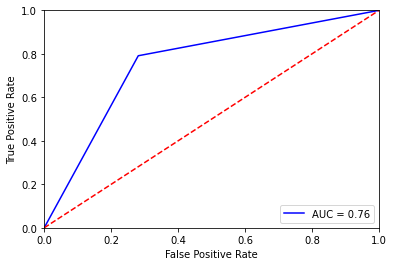

In [49]:
#Training the best model with best parameters, test on test set
best_model = svm.SVC(gamma = 'auto', class_weight = 'balanced', C = 11, kernel = 'rbf')
best_model.fit(X_train, y_train)
y_test_pred = best_model.predict(X_test)
value_of_metrics(y_test, y_test_pred)